In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader
import time as time
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from ModelsKnapSack import KnapSackNet, ValPredictNet
from generate_knapsack_data import Gen_Knapsack_data
from knapsack_utils import RegretLoss
from Trainer import trainer
import matplotlib.pyplot as plt

# Set the random seed
seed = 42
torch.manual_seed(seed)

Auto-Sklearn cannot be imported.


In [2]:
# Data parameters
num_knapsack = 2
num_item = 10
num_feat = 10
num_data = 1000
# Load Data
state = Gen_Knapsack_data(num_data, num_feat, num_item, num_knapsack)

Generating training data for knapsack problem with 2 knapsacks and 10 items
Restricted license - for non-production use only - expires 2024-10-28
Optimizing for optDataset...


100%|█████████████████████████████████████████| 900/900 [00:00<00:00, 1389.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 1448.35it/s]

Finished building dataset


In [3]:
weights_numpy = state["weights_numpy"]
capacities = state["capacities"]
dataset_train = state["dataset_train"]
dataset_test = state["dataset_test"]
contexts_numpy = state["contexts_numpy"]

In [4]:
# Initialize DYS_net
device = 'mps'
weights = torch.Tensor(weights_numpy).to(device)
capacities_DYS = capacities.to(device)
DYS_net = KnapSackNet(weights, capacities_DYS, num_knapsack, num_item, num_feat, device=device)
DYS_net.to(device)

/Users/danielmckenzie/My-Drive/Research/Fixed_Point_Networks/Diff-Opt-Over-Polytopes-Project/SPO_with_DYS/Knapsack_Testing/dYS_opt_net.py:29: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  U, s, VT = torch.linalg.svd(self.A, full_matrices=False)


KnapSackNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [5]:
# Train
max_epochs = 20
learning_rate = 1e-3
test_loss_hist_DYS, epoch_time_hist_DYS, best_test_loss_DYS = trainer(DYS_net, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, model_type = "DYS",
                         device=device)

Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.3289332687854767 epoch time:  0.2962968349456787
epoch:  2 test loss is  0.18943989276885986 epoch time:  0.07810306549072266
epoch:  3 test loss is  0.10809846967458725 epoch time:  0.7843279838562012
epoch:  4 test loss is  0.10631466656923294 epoch time:  1.4594612121582031
epoch:  5 test loss is  0.10417409241199493 epoch time:  1.565906047821045
epoch:  6 test loss is  0.10346057265996933 epoch time:  1.6131610870361328
epoch:  7 test loss is  0.10631466656923294 epoch time:  1.7325780391693115
epoch:  8 test loss is  0.10631466656923294 epoch time:  1.6839659214019775
epoch:  9 test loss is  0.10631466656923294 epoch time:  1.5737311840057373
epoch:  10 test loss is  0.10631466656923294 epoch time:  1.5611817836761475
epoch:  11 test loss is  0.10631466656923294 epoch time:  1.6091060638427734
epoch:  12 test loss is  0.10631466656923294 epoch time:  1.5274598598480225
epoch:  13 test loss is  0.10631466656923294 e

# Preparing the benchmark approaches

In [6]:
torch.manual_seed(seed)
val_net = ValPredictNet(num_knapsack, num_item, num_feat, weights,
                        capacities, device=device)
val_net.to(device)

ValPredictNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [7]:
test_loss_hist_2stage, epoch_time_hist_2stage, best_test_loss_2stage = trainer(val_net, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, 
                         model_type = "Two-stage", device=device)

Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.32215481996536255 epoch time:  0.035308122634887695
epoch:  2 test loss is  0.2525865137577057 epoch time:  0.026706933975219727
epoch:  3 test loss is  0.16268284618854523 epoch time:  0.02544713020324707
epoch:  4 test loss is  0.12308240681886673 epoch time:  0.02524280548095703
epoch:  5 test loss is  0.12379593402147293 epoch time:  0.02591109275817871
epoch:  6 test loss is  0.12807705998420715 epoch time:  0.024871110916137695
epoch:  7 test loss is  0.12843382358551025 epoch time:  0.025705814361572266
epoch:  8 test loss is  0.12914733588695526 epoch time:  0.027877092361450195
epoch:  9 test loss is  0.13164466619491577 epoch time:  0.026617050170898438
epoch:  10 test loss is  0.13307170569896698 epoch time:  0.02590799331665039
epoch:  11 test loss is  0.13378523290157318 epoch time:  0.026027917861938477
epoch:  12 test loss is  0.13093113899230957 epoch time:  0.026792049407958984
epoch:  13 test loss is  0

## Implementing the SPO+ Approach

In [8]:
torch.manual_seed(seed)
val_net2 = ValPredictNet(num_knapsack, num_item, num_feat, weights,
                        capacities, device=device)
val_net2.to(device)

ValPredictNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [9]:
torch.manual_seed(seed)
test_loss_hist_SPO, epoch_time_hist_SPO, best_test_loss_SPO = trainer(val_net2, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, 
                         model_type = "SPO+", device=device)

Num of cores: 1
Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.2761327028274536 epoch time:  0.1737961769104004
epoch:  2 test loss is  0.1352122724056244 epoch time:  0.1432809829711914
epoch:  3 test loss is  0.12022832781076431 epoch time:  0.14559602737426758
epoch:  4 test loss is  0.12094184756278992 epoch time:  0.14959311485290527
epoch:  5 test loss is  0.11630396544933319 epoch time:  0.150374174118042
epoch:  6 test loss is  0.11987156420946121 epoch time:  0.161329984664917
epoch:  7 test loss is  0.11951480805873871 epoch time:  0.1762230396270752
epoch:  8 test loss is  0.11452015489339828 epoch time:  0.20382404327392578
epoch:  9 test loss is  0.11987156420946121 epoch time:  0.23953509330749512
epoch:  10 test loss is  0.12129860371351242 epoch time:  0.26375484466552734
epoch:  11 test loss is  0.12022832781076431 epoch time:  0.27785396575927734
epoch:  12 test loss is  0.11844452470541 epoch time:  0.27623677253723145
epoch:  13 test loss is  0.10

## Differentiable Blackbox Optimization Approach


In [10]:
torch.manual_seed(seed)
val_net3 = ValPredictNet(num_knapsack, num_item, num_feat, weights,
                        capacities, device=device)
val_net3.to(device)

ValPredictNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [11]:
test_loss_hist_BBOpt, epoch_time_hist_BBOpt, best_test_loss_SPO = trainer(val_net3, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, 
                         model_type = "BBOpt", device=device)

Num of cores: 1
Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.34284693002700806 epoch time:  0.32112908363342285
epoch:  2 test loss is  0.34391722083091736 epoch time:  0.4335768222808838
epoch:  3 test loss is  0.34427398443222046 epoch time:  0.5389697551727295
epoch:  4 test loss is  0.336425244808197 epoch time:  0.6286818981170654
epoch:  5 test loss is  0.2978951036930084 epoch time:  0.7827939987182617
epoch:  6 test loss is  0.20299679040908813 epoch time:  0.9380099773406982
epoch:  7 test loss is  0.1348555088043213 epoch time:  1.0525281429290771
epoch:  8 test loss is  0.12807705998420715 epoch time:  1.0910899639129639
epoch:  9 test loss is  0.11915804445743561 epoch time:  1.0683009624481201
epoch:  10 test loss is  0.11880128085613251 epoch time:  1.033696174621582
epoch:  11 test loss is  0.12165536731481552 epoch time:  1.0279967784881592
epoch:  12 test loss is  0.12308240681886673 epoch time:  1.0239121913909912
epoch:  13 test loss is  0.122012

## Perterbed Optimizer Approach

In [12]:
torch.manual_seed(seed)
val_net4 = ValPredictNet(num_knapsack, num_item, num_feat, weights,
                        capacities, device=device)
val_net4.to(device)

ValPredictNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [13]:
test_loss_hist_PertOpt, epoch_time_hist_PertOpt, best_test_loss_PertOpt = trainer(val_net4, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, 
                         model_type = "PertOpt", device=device)

Num of cores: 1
Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.34249016642570496 epoch time:  2.717254877090454
epoch:  2 test loss is  0.2504459619522095 epoch time:  3.1271181106567383
epoch:  3 test loss is  0.1569746732711792 epoch time:  3.639073133468628
epoch:  4 test loss is  0.12129860371351242 epoch time:  3.8379077911376953
epoch:  5 test loss is  0.12486621737480164 epoch time:  4.085493087768555
epoch:  6 test loss is  0.12308240681886673 epoch time:  4.1669111251831055
epoch:  7 test loss is  0.12415269762277603 epoch time:  4.037712097167969
epoch:  8 test loss is  0.12308240681886673 epoch time:  3.8751988410949707
epoch:  9 test loss is  0.12129860371351242 epoch time:  3.7044107913970947
epoch:  10 test loss is  0.12165536731481552 epoch time:  3.5275819301605225
epoch:  11 test loss is  0.1180877611041069 epoch time:  3.31960129737854
epoch:  12 test loss is  0.11987156420946121 epoch time:  3.2318248748779297
epoch:  13 test loss is  0.12236888706

## Fenchel-Young Approach

In [14]:
torch.manual_seed(seed)
val_net5 = ValPredictNet(num_knapsack, num_item, num_feat, weights,
                        capacities, device=device)
val_net5.to(device)

ValPredictNet(
  (fc_1): Linear(in_features=10, out_features=100, bias=True)
  (fc_2): Linear(in_features=100, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [15]:
test_loss_hist_PertOpt_FY, epoch_time_hist_PertOpt_FY, best_test_loss_FY = trainer(val_net5, dataset_train, dataset_test, num_item,
                         num_knapsack, max_epochs, learning_rate, 
                         model_type = "PertOpt-FY", device=device)

Num of cores: 1
Initial test loss is  0.414912611246109
epoch:  1 test loss is  0.32001423835754395 epoch time:  2.9049642086029053
epoch:  2 test loss is  0.2697110176086426 epoch time:  3.8434040546417236
epoch:  3 test loss is  0.16981804370880127 epoch time:  4.602258920669556
epoch:  4 test loss is  0.12629325687885284 epoch time:  5.508409023284912
epoch:  5 test loss is  0.12165536731481552 epoch time:  6.360371828079224
epoch:  6 test loss is  0.12772029638290405 epoch time:  6.803128957748413
epoch:  7 test loss is  0.12950409948825836 epoch time:  7.208797216415405
epoch:  8 test loss is  0.13021762669086456 epoch time:  7.41086483001709
epoch:  9 test loss is  0.13235817849636078 epoch time:  7.574665307998657
epoch:  10 test loss is  0.13271494209766388 epoch time:  7.914287090301514
epoch:  11 test loss is  0.13200142979621887 epoch time:  8.010560035705566
epoch:  12 test loss is  0.13235817849636078 epoch time:  8.035032033920288
epoch:  13 test loss is  0.13235817849636

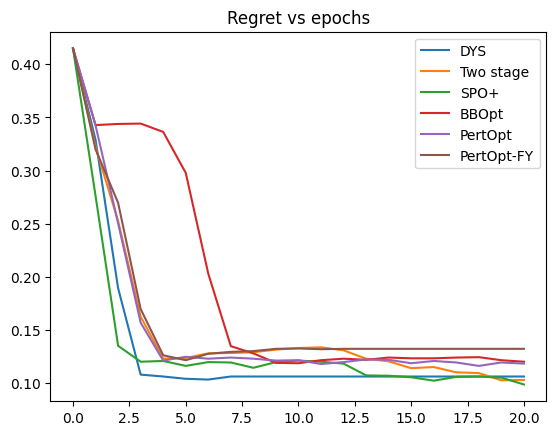

In [16]:
plt.plot(test_loss_hist_DYS, label='DYS')
plt.plot(test_loss_hist_2stage, label='Two stage')
plt.plot(test_loss_hist_SPO, label='SPO+')
plt.plot(test_loss_hist_BBOpt, label="BBOpt")
plt.plot(test_loss_hist_PertOpt, label="PertOpt")
plt.plot(test_loss_hist_PertOpt_FY, label="PertOpt-FY")
plt.legend()
plt.title("Regret vs epochs")
plt.savefig('Knapsack_regret.png')
plt.show()

In [17]:
print(learning_rate)

0.001


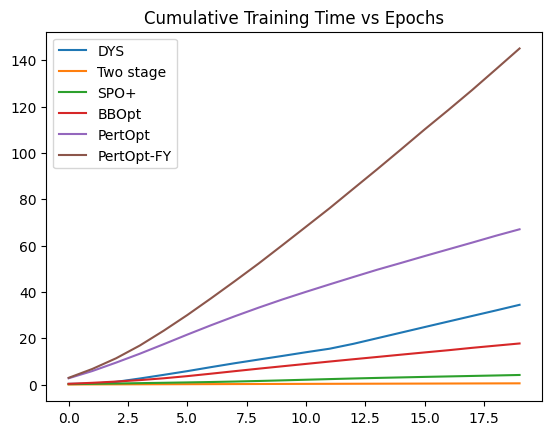

In [18]:
plt.plot(np.cumsum(epoch_time_hist_DYS), label='DYS')
plt.plot(np.cumsum(epoch_time_hist_2stage), label='Two stage')
plt.plot(np.cumsum(epoch_time_hist_SPO), label='SPO+')
plt.plot(np.cumsum(epoch_time_hist_BBOpt), label='BBOpt')
plt.plot(np.cumsum(epoch_time_hist_PertOpt), label='PertOpt')
plt.plot(np.cumsum(epoch_time_hist_PertOpt_FY), label='PertOpt-FY')
plt.legend()
plt.title("Cumulative Training Time vs Epochs")
plt.savefig('Knapsack_train_time.png')
plt.show()